In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn
pd.set_option('use_inf_as_na', True)
from collections import Counter

In [2]:
raw_data = pd.read_pickle(r'C:\Users\niels\OneDrive\Machine Learning 2022\Lecture 2\dataset.pkl')
data = raw_data[raw_data['market_cap'] > 1000.0]
data = data.copy()
data.fillna(0.0,inplace=True)

In [3]:
def f(x):
    if x > 0.01:
        return 1
    elif x < -0.025:
        return -1
    else:
    
        return 0

In [4]:
data['rel_performance'] = data['pred_rel_return'].apply(f)
data.reset_index(inplace=True)
data.set_index('date',inplace=True)

In [5]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = StandardScaler()

## Long term performance with Random Forest Classifier, optimal hyper-parameters

In [6]:
start_dates = [pd.to_datetime('2001-01-01') + pd.DateOffset(months = 3*i) for i in range(57)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

In [168]:
training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
valid_frames = [data.loc[d+pd.DateOffset(months = 3):d+pd.DateOffset(months = 6)] for d in end_dates]
test_frames = [data.loc[d+pd.DateOffset(months = 9):d+pd.DateOffset(months = 12)] for d in end_dates]

In [169]:
training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]

In [170]:
valid_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in valid_frames]

In [171]:
test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

In [172]:
training_labels = [d['rel_performance'].values for d in training_frames]
valid_labels = [d['rel_performance'].values for d in valid_frames] 

In [173]:
for i in range(len(start_dates)-1):
    float_vars = [x for x in training_data[i].columns if data[x].dtype == 'float64']

    scaler = StandardScaler()
    training_data[i] = training_data[i].copy()
    valid_data[i] = valid_data[i].copy()
    test_data[i] = test_data[i].copy()
    training_data[i][float_vars] = scaler.fit_transform(training_data[i][float_vars])
    valid_data[i][float_vars] = scaler.transform(valid_data[i][float_vars])
    test_data[i][float_vars] = scaler.transform(test_data[i][float_vars])
        
    

In [177]:
import optuna
from optuna.trial import Trial
optuna.logging.set_verbosity(optuna.logging.FATAL)
import warnings
warnings.filterwarnings("ignore")

In [178]:
def objective(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None):

    rf_n_estimators = trial.suggest_int('n_estimators', 10,40,step=5)
    rf_max_features = trial.suggest_categorical('max_features',['sqrt','log2'])
    rf_min_samples_leaf = trial.suggest_int('min_samples_leaf',400,2400,step=400)
    rf_max_depth = trial.suggest_int('max_depth',5,25,step=5)
    
    rf_clf = RandomForestClassifier(n_estimators=rf_n_estimators,
                                    max_depth=rf_max_depth,
                                    min_samples_leaf=rf_min_samples_leaf,
                                    max_features=rf_max_features)
    rf_clf.fit(train,labels)
    preds = rf_clf.predict(val)
    profit = (preds * val_rets).sum()
 
    return profit

In [179]:
optimal_hyperparameters = []

In [180]:
from functools import partial

In [182]:
for i in range(len(start_dates)-1):
    
    study = optuna.create_study(direction="maximize")
    
    study.optimize(partial(objective,
                           train=training_data[i],
                           labels=training_labels[i],
                           val=valid_data[i],
                           val_rets=valid_frames[i]['next_period_return']), n_trials=200,n_jobs=-1)
    
    optimal_hyperparameters.append(study.best_params)  
    print(study.best_params)
    

{'n_estimators': 10, 'max_features': 'sqrt', 'min_samples_leaf': 400, 'max_depth': 20}
{'n_estimators': 40, 'max_features': 'sqrt', 'min_samples_leaf': 400, 'max_depth': 20}
{'n_estimators': 10, 'max_features': 'log2', 'min_samples_leaf': 400, 'max_depth': 25}
{'n_estimators': 20, 'max_features': 'sqrt', 'min_samples_leaf': 400, 'max_depth': 25}
{'n_estimators': 10, 'max_features': 'log2', 'min_samples_leaf': 400, 'max_depth': 10}
{'n_estimators': 10, 'max_features': 'sqrt', 'min_samples_leaf': 400, 'max_depth': 25}
{'n_estimators': 30, 'max_features': 'log2', 'min_samples_leaf': 2400, 'max_depth': 25}
{'n_estimators': 25, 'max_features': 'sqrt', 'min_samples_leaf': 400, 'max_depth': 10}
{'n_estimators': 10, 'max_features': 'sqrt', 'min_samples_leaf': 400, 'max_depth': 15}
{'n_estimators': 15, 'max_features': 'log2', 'min_samples_leaf': 1200, 'max_depth': 20}
{'n_estimators': 40, 'max_features': 'sqrt', 'min_samples_leaf': 800, 'max_depth': 10}
{'n_estimators': 15, 'max_features': 'sqr

In [174]:
import _pickle as cPickle

In [183]:
with open(r'optimal_hyperparameters.pkl','wb') as f:
    cPickle.dump(optimal_hyperparameters,f)

In [184]:
with open(r'optimal_hyperparameters.pkl','rb') as f:
    optimal_hyperparameters = cPickle.load(f)

In [185]:
optimal_hyperparameters

[{'n_estimators': 10,
  'max_features': 'sqrt',
  'min_samples_leaf': 400,
  'max_depth': 20},
 {'n_estimators': 10,
  'max_features': 'sqrt',
  'min_samples_leaf': 2400,
  'max_depth': 10},
 {'n_estimators': 20,
  'max_features': 'log2',
  'min_samples_leaf': 400,
  'max_depth': 15},
 {'n_estimators': 10,
  'max_features': 'sqrt',
  'min_samples_leaf': 400,
  'max_depth': 25},
 {'n_estimators': 30,
  'max_features': 'log2',
  'min_samples_leaf': 1600,
  'max_depth': 15},
 {'n_estimators': 10,
  'max_features': 'sqrt',
  'min_samples_leaf': 400,
  'max_depth': 25},
 {'n_estimators': 20,
  'max_features': 'log2',
  'min_samples_leaf': 2400,
  'max_depth': 20},
 {'n_estimators': 10,
  'max_features': 'sqrt',
  'min_samples_leaf': 400,
  'max_depth': 10},
 {'n_estimators': 20,
  'max_features': 'log2',
  'min_samples_leaf': 2400,
  'max_depth': 25},
 {'n_estimators': 10,
  'max_features': 'log2',
  'min_samples_leaf': 800,
  'max_depth': 25},
 {'n_estimators': 25,
  'max_features': 'log2'

In [186]:
classifiers = []

In [187]:
for hyp_par in optimal_hyperparameters:
    rf_clf = RandomForestClassifier(**hyp_par)
    classifiers.append(rf_clf)

In [189]:
for i in range(len(start_dates)-1): 
    classifiers[i].fit(training_data[i],training_labels[i])

In [190]:
with open(r'classifiers.pkl','wb') as f:
    cPickle.dump(classifiers,f)

In [191]:
with open(r'classifiers.pkl','rb') as f:
    classifiers = cPickle.load(f)

In [192]:
def randomforest_feat_importances(m, df):
        
    return pd.DataFrame({'cols':df.columns, 'feat_imp': m.feature_importances_}
                       ).sort_values('feat_imp', ascending=False)

def plot_fi(fi): return fi.plot('cols', 'feat_imp', 'barh', figsize=(12,7), legend=False)

In [193]:
significant_features = []

In [194]:
for i in range(len(start_dates)-1): 
    fi = randomforest_feat_importances(classifiers[i],training_data[i])
    features = fi[(fi['feat_imp'] > 0.00)]['cols'].values
    significant_features.append(features)

In [195]:
significant_features

[array(['oiadpq', 'prccq', 'fcf_yield', 'rd_saleq', 'oepf12', 'ptpmq',
        'opmadq', 'oepsxy', 'oeps12', 'pe_op_dilq', 'quick_ratioq',
        'curr_ratioq', 'epsf12', 'ibadj12', 'fcf_csfhdq', 'rect_actq',
        'epsfiq', 'epsfi12', 'npmq', 'cfo-per-share', 'oepsxq',
        'curr_debtq', 'cogsy', 'at4', 'oancfy_q', 'capxq', 'gpmq',
        'at_turnq', 'de_ratioq', 'beq', 'epsfxq', 'book_value_yield',
        'sale_invcapq', 'capeiq', 'pretret_noaq', 'txtq', 'dvpspq',
        'revtq', 'actq', 'capxy', 'ltq', 'xintq', 'ibcomy', 'psq',
        'lt_debtq', 'be4', 'oancfy', 'cf_yield', 'cash_debtq', 'csh12q',
        'saleq', 'cash_conversionq', 'cash_ratioq', 'efftaxq', 'dvq',
        'rect_turnq', 'debt_assetsq', 'epspiq', 'pay_turnq', 'xsgay',
        'dlttq', 'icaptq', 'debt_atq', 'req', 'ceqq', 'ocf_lctq', 'roaq',
        'opcfq', 'nopiq', 'revty', 'int_debtq', 'chechy', 'ceq4', 'opepsq',
        'lagppent4', 'opmbdq', 'debt_invcapq', 'debt_ebitdaq', 'inv_turnq',
        'cfmq',

In [196]:
with open(r'significant_features.pkl','wb') as f:
    cPickle.dump(significant_features,f)

In [197]:
with open(r'significant_features.pkl','rb') as f:
    significant_features = cPickle.load(f)

In [198]:
new_training_data = []
new_valid_data = []
new_test_data = []

In [199]:
for i in range(len(start_dates)-1): 
    new_training_data.append(training_data[i][significant_features[i]])
    new_valid_data.append(valid_data[i][significant_features[i]])
    new_test_data.append(test_data[i][significant_features[i]])
    

In [200]:
new_valid_data[1].columns

Index(['cash_ratioq', 'dvq', 'pe_op_basicq', 'oepsxq', 'epspxq', 'revty',
       'cash_ltq', 'capeiq', 'pe_incq'],
      dtype='object')

In [201]:
for i in range(len(start_dates)-1):
    float_vars = [x for x in new_training_data[i].columns if data[x].dtype == 'float64']

    scaler = StandardScaler()
    new_training_data[i] = new_training_data[i].copy()
    new_valid_data[i] = new_valid_data[i].copy()
    new_test_data[i] = new_test_data[i].copy()
    new_training_data[i][float_vars] = scaler.fit_transform(new_training_data[i][float_vars])
    new_valid_data[i][float_vars] = scaler.transform(new_valid_data[i][float_vars])
    new_test_data[i][float_vars] = scaler.transform(new_test_data[i][float_vars])

In [202]:
for i in range(len(start_dates)-1): 
    classifiers[i].fit(new_training_data[i],training_labels[i])

In [204]:
with open(r'classifiers.pkl','wb') as f:
    cPickle.dump(classifiers,f)

In [205]:
with open(r'classifiers.pkl','rb') as f:
    classifiers = cPickle.load(f)

In [206]:
def model(features):
    tree_features = features[features.columns[:-1].values]

    pred = rf_clf.predict(tree_features)

    ret = pred * features[features.columns[-1]]

    return ret

In [207]:
import shap

In [208]:
shap_features = []

In [209]:
for i in range(len(start_dates)-1):
    
    valid_1 = new_valid_data[i].copy()
    cols = new_valid_data[i].columns
    
    print(len(cols))
    
    valid_1['rets'] = valid_frames[i]['next_period_return'].values
    
    rf_clf = classifiers[i]
    
    explainer = shap.explainers.Permutation(model,valid_1)
    shap_values = explainer(valid_1,max_evals=1000,)
    
    shap_cols = cols[np.abs(shap_values[:,:-1].values).mean(axis=0)>0.000]
    
    if shap_cols.empty:
        shap_cols = cols[:10]
        
    print(len(shap_cols))
    
    shap_features.append(shap_cols)
    

88


PermutationExplainer explainer: 1156it [04:11,  4.46it/s]                                                              


50
9


PermutationExplainer explainer: 1174it [04:32,  4.14it/s]                                                              


9
113


PermutationExplainer explainer: 1137it [06:34,  2.81it/s]                                                              


80
88


PermutationExplainer explainer: 1266it [04:40,  4.33it/s]                                                              


59
57


PermutationExplainer explainer: 1261it [06:54,  2.97it/s]                                                              


10
85


PermutationExplainer explainer: 1256it [04:35,  4.39it/s]                                                              


54
28


PermutationExplainer explainer: 1284it [05:09,  4.01it/s]                                                              


10
84


PermutationExplainer explainer: 1316it [04:07,  5.09it/s]                                                              


50
26


PermutationExplainer explainer: 1414it [05:00,  4.55it/s]                                                              


10
62


PermutationExplainer explainer: 1361it [03:40,  5.92it/s]                                                              


10
145


PermutationExplainer explainer: 1355it [09:08,  2.42it/s]                                                              


119
164


PermutationExplainer explainer: 1475it [15:41,  1.55it/s]                                                              


147
124


PermutationExplainer explainer: 1512it [08:37,  2.86it/s]                                                              


89
124


PermutationExplainer explainer: 1523it [09:28,  2.63it/s]                                                              


96
114


PermutationExplainer explainer: 1499it [05:50,  4.15it/s]                                                              


85
111


PermutationExplainer explainer: 1455it [05:28,  4.30it/s]                                                              


90
107


PermutationExplainer explainer: 1400it [04:58,  4.54it/s]                                                              


89
109


PermutationExplainer explainer: 1376it [04:55,  4.49it/s]                                                              


89
168


PermutationExplainer explainer: 1301it [10:23,  2.05it/s]                                                              


161
98


PermutationExplainer explainer: 1099it [04:11,  4.20it/s]                                                              


83
155


PermutationExplainer explainer: 1029it [06:39,  2.51it/s]                                                              


126
95


PermutationExplainer explainer: 1180it [04:13,  4.47it/s]                                                              


77
120


PermutationExplainer explainer: 1279it [05:18,  3.89it/s]                                                              


98
48


PermutationExplainer explainer: 1353it [06:02,  3.63it/s]                                                              


10
160


PermutationExplainer explainer: 1442it [11:08,  2.13it/s]                                                              


140
108


PermutationExplainer explainer: 1388it [04:55,  4.53it/s]                                                              


79
54


PermutationExplainer explainer: 1443it [04:45,  4.87it/s]                                                              


10
144


PermutationExplainer explainer: 1554it [13:13,  1.93it/s]                                                              


10
88


PermutationExplainer explainer: 1547it [06:08,  4.09it/s]                                                              


10
118


PermutationExplainer explainer: 1612it [08:00,  3.28it/s]                                                              


6
157


PermutationExplainer explainer: 1426it [13:14,  1.77it/s]                                                              


121
110


PermutationExplainer explainer: 1528it [06:11,  4.03it/s]                                                              


78
112


PermutationExplainer explainer: 1610it [10:43,  2.48it/s]                                                              


10
115


PermutationExplainer explainer: 1619it [06:49,  3.86it/s]                                                              


91
137


PermutationExplainer explainer: 1531it [07:25,  3.36it/s]                                                              


117
107


PermutationExplainer explainer: 1625it [05:47,  4.54it/s]                                                              


91
57


PermutationExplainer explainer: 1751it [05:23,  5.24it/s]                                                              


10
60


PermutationExplainer explainer: 1802it [05:57,  4.90it/s]                                                              


51
106


PermutationExplainer explainer: 1875it [10:12,  3.01it/s]                                                              


76
65


PermutationExplainer explainer: 1957it [07:16,  4.37it/s]                                                              


45
76


PermutationExplainer explainer: 1969it [07:41,  4.16it/s]                                                              


51
144


PermutationExplainer explainer: 2061it [11:32,  2.93it/s]                                                              


128
96


PermutationExplainer explainer: 1973it [07:50,  4.10it/s]                                                              


75
47


PermutationExplainer explainer: 2042it [08:28,  3.93it/s]                                                              


30
115


PermutationExplainer explainer: 2081it [09:54,  3.43it/s]                                                              


101
73


PermutationExplainer explainer: 2136it [10:15,  3.42it/s]                                                              


30
106


PermutationExplainer explainer: 1949it [07:10,  4.41it/s]                                                              


82
92


PermutationExplainer explainer: 1965it [07:36,  4.22it/s]                                                              


78
149


PermutationExplainer explainer: 1951it [14:51,  2.17it/s]                                                              


137
127


PermutationExplainer explainer: 2006it [07:54,  4.14it/s]                                                              


116
172


PermutationExplainer explainer: 2006it [15:26,  2.14it/s]                                                              


162
57


PermutationExplainer explainer: 2067it [06:20,  5.30it/s]                                                              


34
173


PermutationExplainer explainer: 2109it [19:56,  1.75it/s]                                                              


161
129


PermutationExplainer explainer: 2155it [11:58,  2.96it/s]                                                              


105
168


PermutationExplainer explainer: 2155it [15:37,  2.27it/s]                                                              

161


In [211]:
with open(r'shap_features.pkl','wb') as f:
    cPickle.dump(shap_features,f)

In [212]:
with open(r'shap_features.pkl','rb') as f:
    shap_features = cPickle.load(f)

In [213]:
start_dates = [pd.to_datetime('2001-01-01') + pd.DateOffset(months = 3*i) for i in range(56)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

In [214]:
training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
test_frames = [data.loc[d+pd.DateOffset(months = 9):d+pd.DateOffset(months = 12)] for d in end_dates]

In [113]:
training_labels = [d['rel_performance'].values for d in training_frames]

In [215]:
scalers = [StandardScaler() for i in range(len(start_dates)-1)]
           
opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features[i]].values),columns=shap_features[i]) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_features[i]].values),columns=shap_features[i]) for i in range(len(start_dates)-1)]

In [216]:
x = [1]
ret = []

for i in range(len(start_dates)-1):
        
        classifiers[i].fit(opt_training_data[i],training_labels[i])

        preds = classifiers[i].predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x.append(x[i] + (x[i]/num_names)*profit_i)

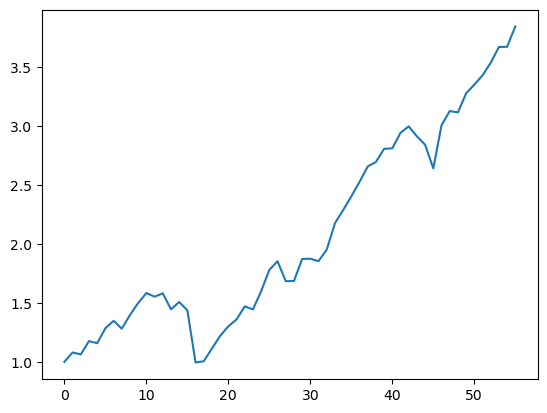

In [217]:
plt.plot(x);

In [218]:
len(x)

56

In [219]:
SPY = pd.read_pickle(r'C:\Users\niels\OneDrive\Machine Learning 2022\Lecture 2\SPY_cum_ret.pkl')
SPY = SPY.loc['2005-01-01':'2018-12-01']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x

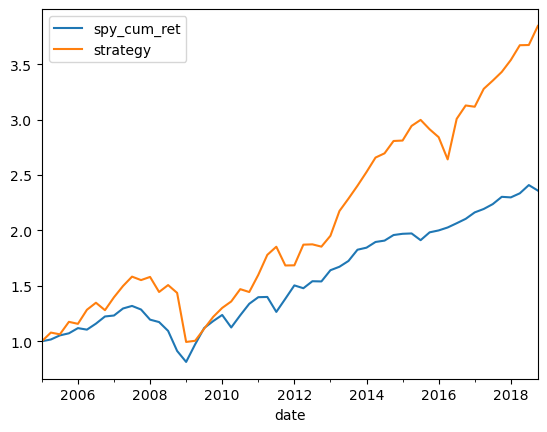

In [220]:
SPY.plot();

In [221]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

Strategy Sharpe Ratio:  0.43179802110447


In [222]:
 (SPY['strategy'] - 1).diff().std()

0.11984647603033143

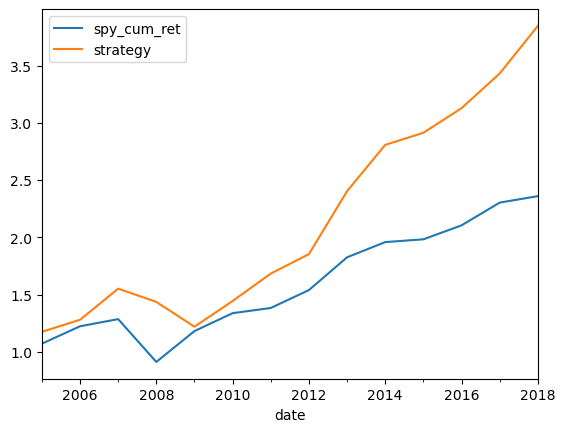

In [223]:
SPY = SPY.resample('Y').ffill()
SPY.plot();

In [233]:
SPY

,spy_cum_ret,strategy
date,,
2005-12-31,1.071600,1.175280
2006-12-31,1.223723,1.280491
2007-12-31,1.286391,1.552134
2008-12-31,0.912606,1.436571
2009-12-31,1.181998,1.220051
2010-12-31,1.338326,1.444376
2011-12-31,1.383535,1.683986
2012-12-31,1.539919,1.853967
2013-12-31,1.826140,2.403830


In [234]:
with open(r'rf strategy.pkl','wb') as f:
    cPickle.dump(SPY['strategy'].values,f)

In [235]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

Strategy Sharpe Ratio:  0.9871386064234094


In [236]:
x[-1]

3.8462209152432774

In [237]:
strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]

In [238]:
beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]

In [239]:
beta 

0.5040288914314816

In [240]:
strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]
beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
print('beta: ',beta)
residual_ret = strategy_ret - beta * spy_ret
IR = np.mean(residual_ret)/np.std(residual_ret)
print('Information Ratio: ',IR)

beta:  0.5040288914314816
Information Ratio:  0.8348508236322844


In [241]:
alpha = np.mean(residual_ret)

In [242]:
alpha

0.15549869715525858